<a href="https://colab.research.google.com/github/michaellopes16/DataScience/blob/main/Atividade_05_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

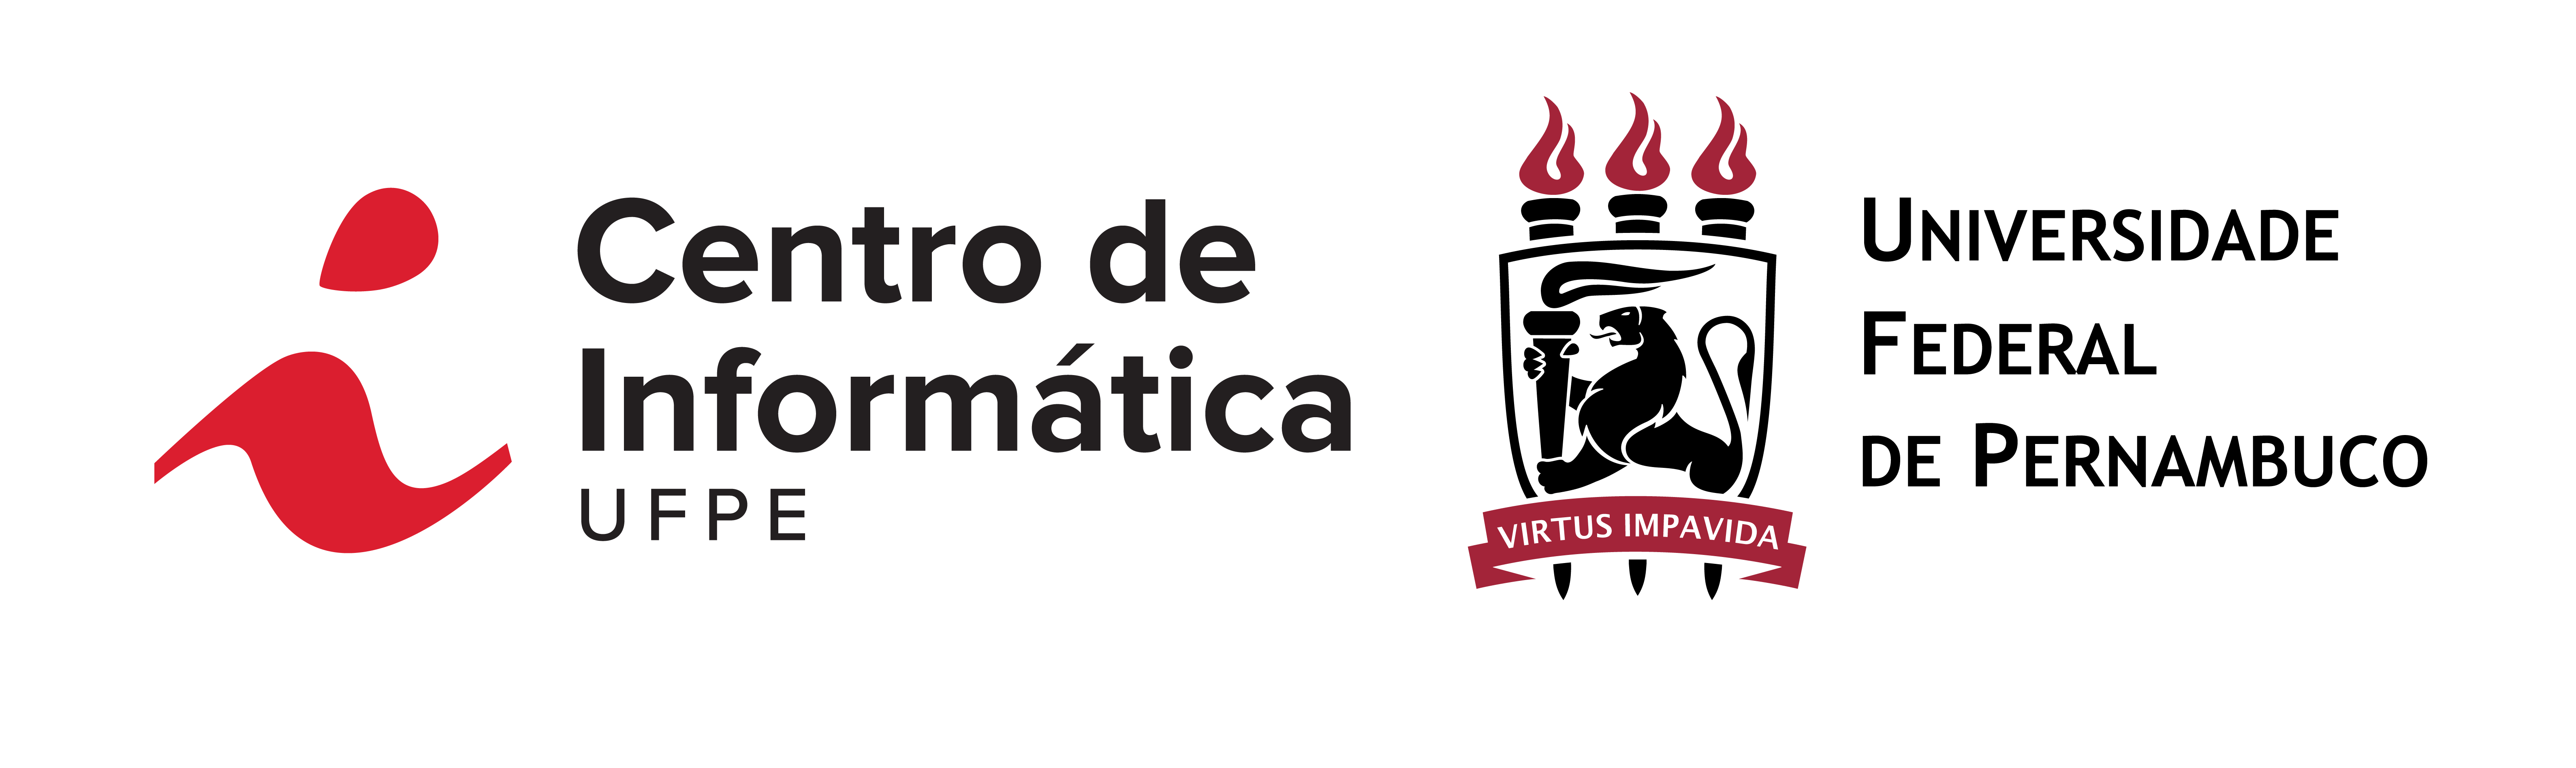

Prof. Dr. Leandro Maciel Almeida

**Equipe:** 

*   José William Araújo do Nascimento
*   Michael Lopes Bastos
*   Ricardo Helisson Bezerra Amorim

# Atividade 05 - SVM
---
Para atender minimamente o desafio em questão, primeiro foi feito uma análise a respeito do domínio do problema e das características dos dados. 




In [ ]:
import pandas as pd
import numpy as np
import sys
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
from google.colab import drive
sns.set_theme()

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn import preprocessing
from sklearn.svm import SVC 
from sklearn.model_selection import GridSearchCV

from keras.utils import to_categorical
%matplotlib inline


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Load Data

In [ ]:
columsNames = ["ID", "RI","Na","Mg","Al","Si","k","Ca","Ba","Fe","TypeOfGlass"]
columsNamesX = ["RI","Na","Mg","Al","Si","k","Ca","Ba","Fe"]
y_vars = ["building_windows_float_processed","building_windows_non_float_processed", 
          "vehicle_windows_float_processed", "containers","tableware","headlamps"]
          #,"vehicle_windows_non_float_processed" faltante
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/AM/atividade5/glass.data", sep=",", header=None, 
                 names=columsNames)

df.drop(columns=['ID'], inplace=True)

In [ ]:
df.head()

RI     Na    Mg    Al     Si     k    Ca   Ba   Fe  TypeOfGlass
0  1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.0  0.0            1
1  1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.0            1
2  1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.0            1
3  1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.0            1
4  1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.0  0.0            1

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   RI           214 non-null    float64
 1   Na           214 non-null    float64
 2   Mg           214 non-null    float64
 3   Al           214 non-null    float64
 4   Si           214 non-null    float64
 5   k            214 non-null    float64
 6   Ca           214 non-null    float64
 7   Ba           214 non-null    float64
 8   Fe           214 non-null    float64
 9   TypeOfGlass  214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


# Visualização geral da correlação dos dados




/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


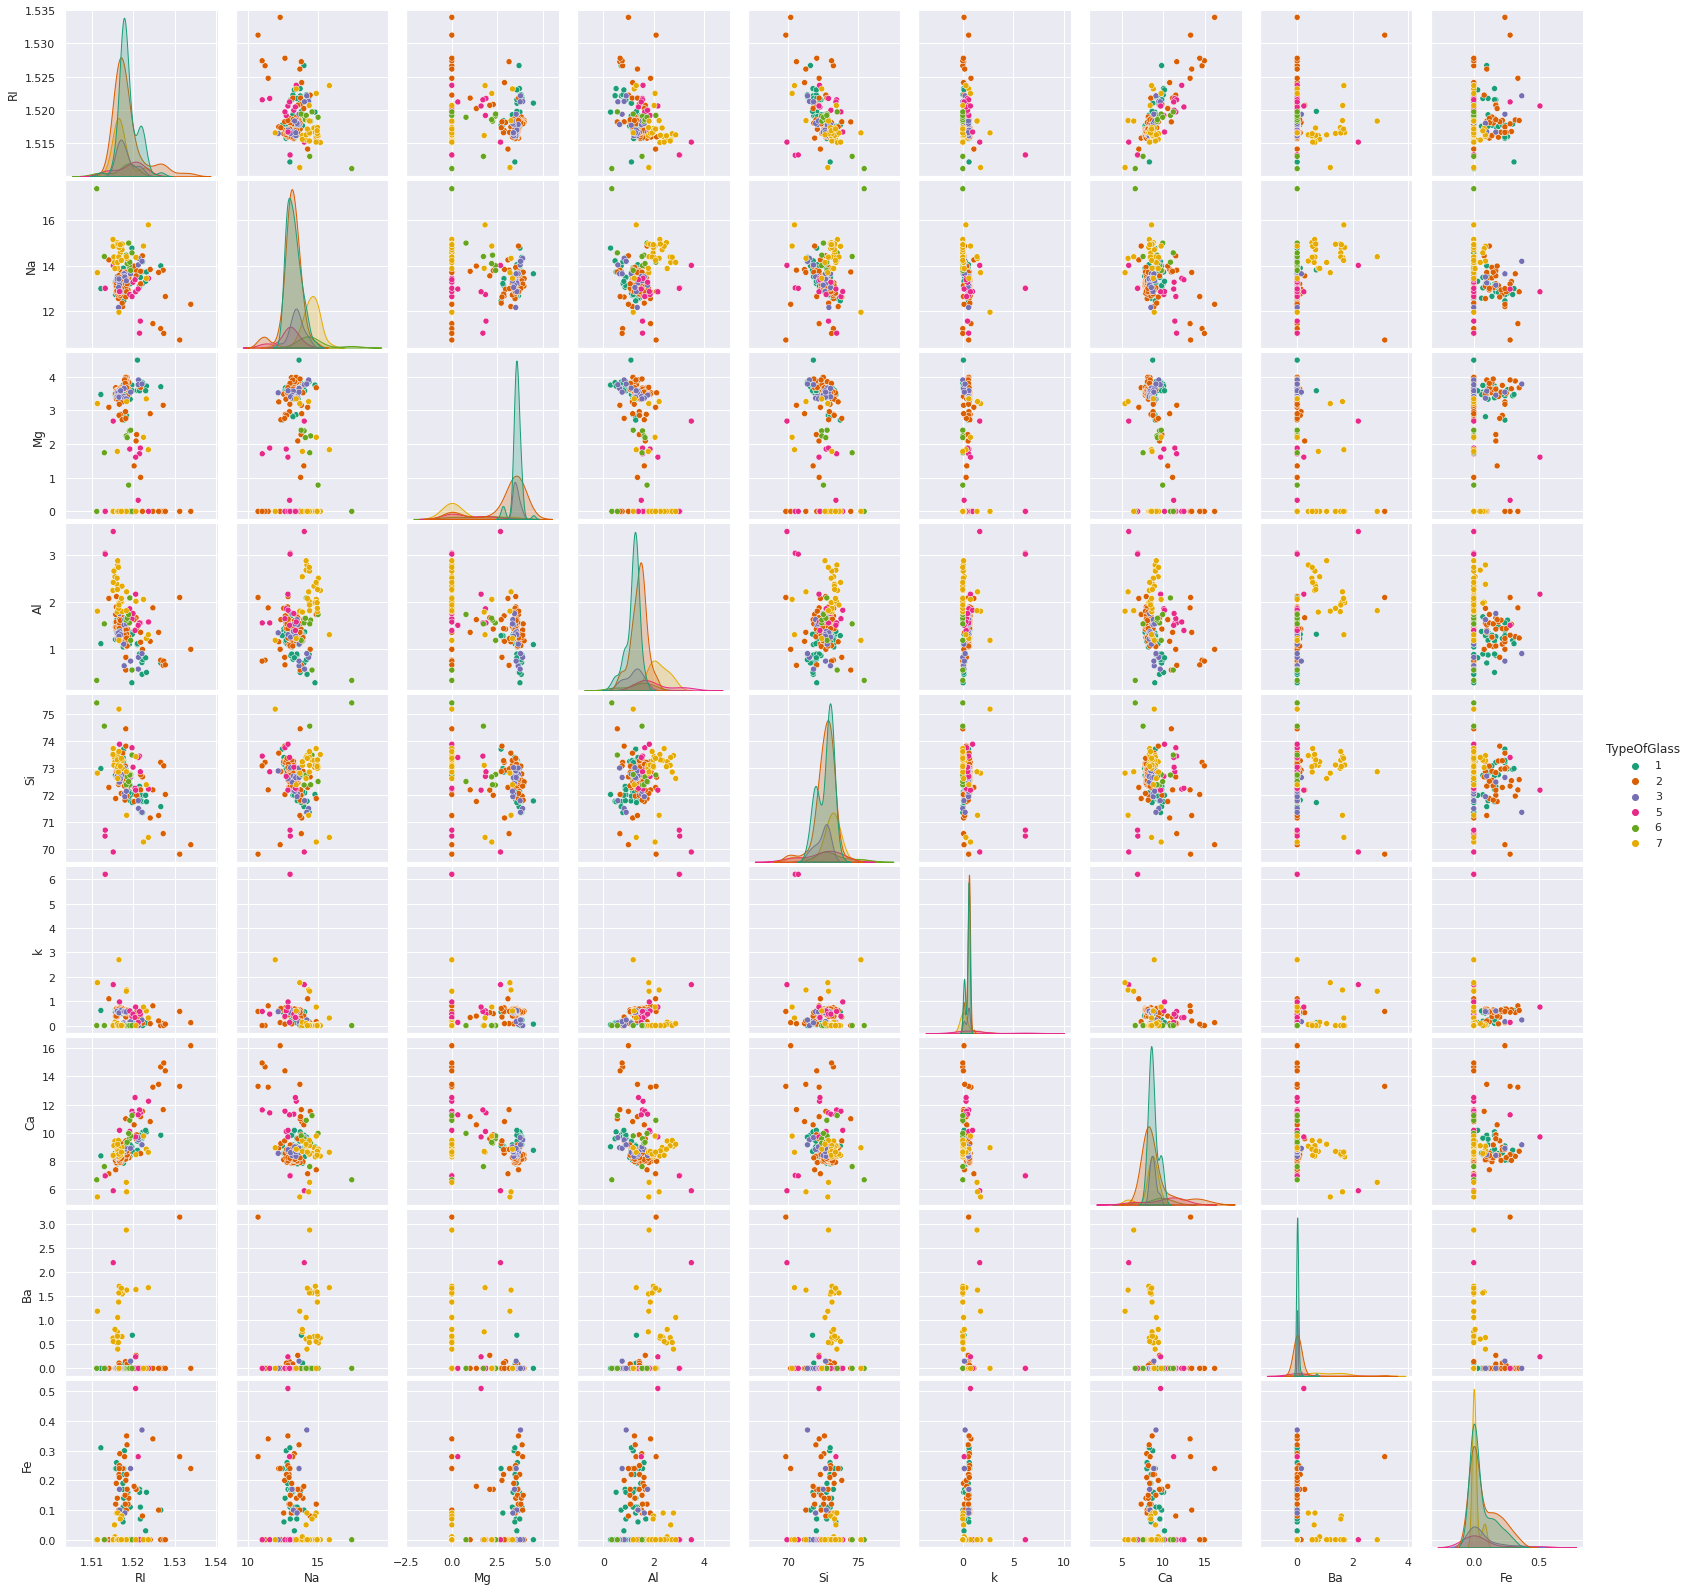

In [ ]:
g = sns.pairplot(df,hue='TypeOfGlass',palette='Dark2')
#g.add_legend(title="Distribuição dos dados", adjust_subtitles=True)

# Normalização dos dados

In [ ]:

min_max_scaler = preprocessing.MinMaxScaler()
#standardScaler = preprocessing.StandardScaler()
y = df['TypeOfGlass']
x_scaled = min_max_scaler.fit_transform(df[columsNamesX])
#df_scaled = standardScaler.fit_transform(df)
x_scaled = pd.DataFrame(x_scaled, columns=columsNamesX)


In [ ]:
x_scaled.head()

RI        Na        Mg        Al  ...         k        Ca   Ba   Fe
0  0.432836  0.437594  1.000000  0.252336  ...  0.009662  0.308550  0.0  0.0
1  0.283582  0.475188  0.801782  0.333333  ...  0.077295  0.223048  0.0  0.0
2  0.220808  0.421053  0.790646  0.389408  ...  0.062802  0.218401  0.0  0.0
3  0.285777  0.372932  0.821826  0.311526  ...  0.091787  0.259294  0.0  0.0
4  0.275241  0.381955  0.806236  0.295950  ...  0.088567  0.245353  0.0  0.0

[5 rows x 9 columns]

In [ ]:
x_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   k       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
dtypes: float64(9)
memory usage: 15.2 KB


In [ ]:
y.value_counts()

2    76
1    70
7    29
3    17
5    13
6     9
Name: TypeOfGlass, dtype: int64

Redução da dimensionalidade da base (PCA) para analise do comportamento dos dados

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x_scaled)
result = pd.DataFrame(data = principalComponents
             , columns = ['PCA0', 'PCA1','PCA2'])

Text(0.5, 0.92, 'PCA on the iris data set')

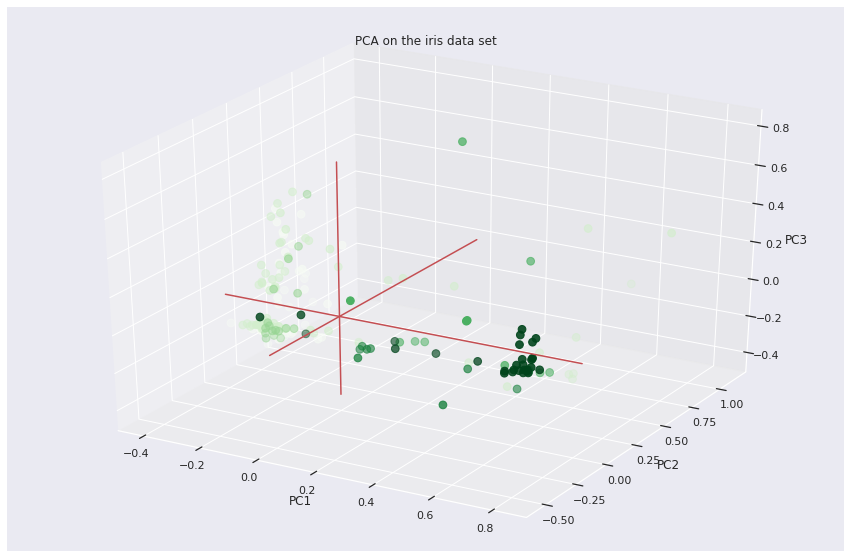

In [ ]:
# Plot initialisation
df['TypeOfGlass']=pd.Categorical(df['TypeOfGlass'])
my_color=df['TypeOfGlass'].cat.codes

fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(result['PCA0'], result['PCA1'], result['PCA2'], c=my_color, cmap="Greens", s=60)
 
# make simple, bare axis lines through space:
xAxisLine = ((min(result['PCA0']), max(result['PCA0'])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(result['PCA1']), max(result['PCA1'])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(result['PCA2']), max(result['PCA2'])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("PCA on the glass data set")
#plt.show()

Oversampling (Ajuste de proporcionalidade)

![alt text](https://miro.medium.com/max/375/1*aKJJOozIlVVH1gT-4rYy4w.png)

In [ ]:
#ver possibilidade de fazer isso mais de uma vez, recursivamente
print(len(y.value_counts()))
oversample = RandomOverSampler(sampling_strategy='minority')
for i in range(len(y.value_counts())):
    oversample.fit(x_scaled,y)
    x_res , y_res = oversample.fit_resample(x_scaled,y)
    y = y_res
    x_scaled = x_res

6


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [ ]:
print(x_res.shape)
print(y_res.shape)

(456, 9)
(456,)


In [ ]:
pd.DataFrame(y_res).value_counts()

7    76
6    76
5    76
3    76
2    76
1    76
dtype: int64

# RepeatedKFold

In [ ]:
#5x10
rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=2652124)


Definição de parâmetros SVM

Fazer OneVsOne

In [ ]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid','linear']}
kernels = ['Polynomial', 'RBF', 'Sigmoid','Linear']#A function which returns the corresponding SVC model
def getClassifier(ktype):
    if ktype == 0:
        # Polynomial kernal
        return SVC(kernel='poly', degree=8, gamma="auto", decision_function_shape='ovo')
    elif ktype == 1:
        # Radial Basis Function kernal
        return SVC(kernel='rbf', gamma="auto",decision_function_shape='ovo')
    elif ktype == 2:
        # Sigmoid kernal
        return SVC(kernel='sigmoid', gamma="auto",decision_function_shape='ovo')
    elif ktype == 3:
        # Linear kernal
        return SVC(kernel='linear', gamma="auto",decision_function_shape='ovo')

In [ ]:
for i in range(4):
    # Separate data into test and training sets
    X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size = 0.20)# Train a SVC model using different kernal
    svclassifier = getClassifier(i) 
    svclassifier.fit(X_train, y_train)# Make prediction
    y_pred = svclassifier.predict(X_test)# Evaluate our model
    print("Evaluation:", kernels[i], "kernel")
    print(classification_report(y_test,y_pred))

Evaluation: Polynomial kernel
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00        24
           3       0.00      0.00      0.00        16
           5       0.00      0.00      0.00        16
           6       0.12      1.00      0.21        11
           7       0.00      0.00      0.00        12

    accuracy                           0.12        92
   macro avg       0.02      0.17      0.04        92
weighted avg       0.01      0.12      0.03        92

Evaluation: RBF kernel
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        15
           2       0.17      0.82      0.28        11
           3       0.00      0.00      0.00        19
           5       0.83      0.83      0.83        12
           6       1.00      0.59      0.74        22
           7       0.85      0.85      0.85        13

    accuracy            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

# Fazer busca por parâmebros

In [ ]:
kernels =  ['rbf', 'poly', 'sigmoid','linear']
C = [0.1,1, 10, 100]
gamma = [1,0.1,0.01,0.001]

def runModels(kernels, cPara, gamma):

    lambdaC = [atribuirTrainTest(train_index, test_index, k, c, g) for k in kernels for g in gamma for c in cPara for train_index, test_index in rkf.split(x_res)]
    return pd.DataFrame(lambdaC,columns=["K","C","Gamma","MeanScoreTraining","MeanScoreTest"])

def atribuirTrainTest(train_index, test_index, k, c, g):
    X_train, X_test = x_res[train_index], x_res[test_index]
    y_train, y_test = y_res[train_index], y_res[test_index]
    svm = SVC(kernel=k, degree=8, gamma=g,C=c,decision_function_shape='ovo').fit(X_train, y_train) 
    treiningScore = svm.fit(X_train,y_train).score(X_train,y_train)
    y_pred = svm.predict(X_test)

    return [k, c, g, treiningScore, accuracy_score(y_test, y_pred)]

df_results = runModels(kernels, C, gamma)
df_results

K      C  Gamma  MeanScoreTraining  MeanScoreTest
0        rbf    0.1  1.000           0.568681       0.500000
1        rbf    0.1  1.000           0.591781       0.472527
2        rbf    0.1  1.000           0.580822       0.549451
3        rbf    0.1  1.000           0.526027       0.472527
4        rbf    0.1  1.000           0.556164       0.505495
...      ...    ...    ...                ...            ...
3195  linear  100.0  0.001           0.879121       0.880435
3196  linear  100.0  0.001           0.887671       0.780220
3197  linear  100.0  0.001           0.854795       0.868132
3198  linear  100.0  0.001           0.882192       0.835165
3199  linear  100.0  0.001           0.863014       0.868132

[3200 rows x 5 columns]

Config:      index    K      C  Gamma  MeanScoreTraining  MeanScoreTest
157    157  rbf  100.0    1.0           0.923288       0.945055
192    192  rbf  100.0    1.0           0.931507       0.945055, Index:157
Média da acurácia para todas as variações do kernel rbf: 0.47201788700430086 
Média do desvio padrão 0.2773592283796166
-------------------------------------------------------------------------------------------------
Config:      index     K      C  Gamma  MeanScoreTraining  MeanScoreTest
57     857  poly    1.0    1.0           0.915068       0.978022
107    907  poly   10.0    1.0           0.969863       0.978022
157    957  poly  100.0    1.0           0.986301       0.978022, Index:57
Média da acurácia para todas as variações do kernel poly: 0.31389856067845284 
Média do desvio padrão 0.3221050655080368
-------------------------------------------------------------------------------------------------
Config:      index        K      C  Gamma  MeanScoreTraining  MeanScoreTes

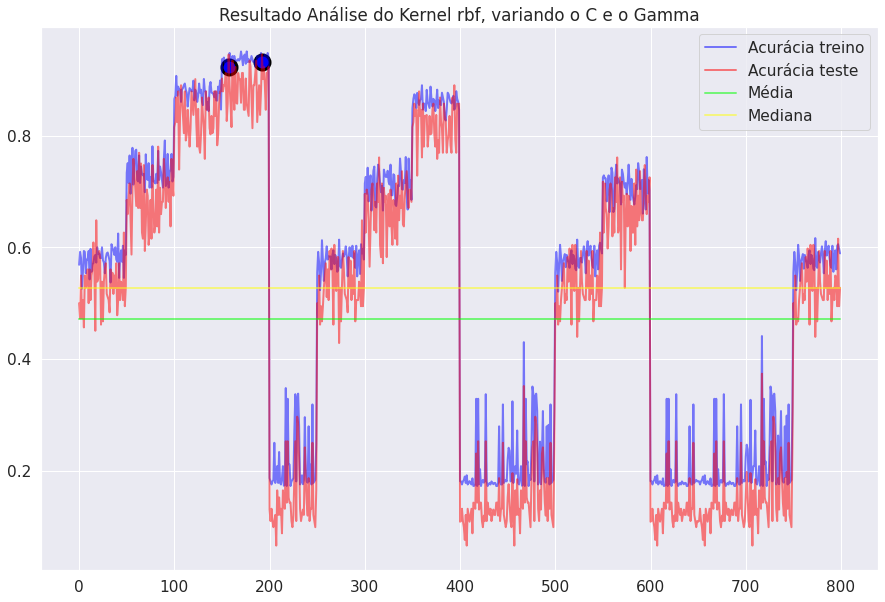

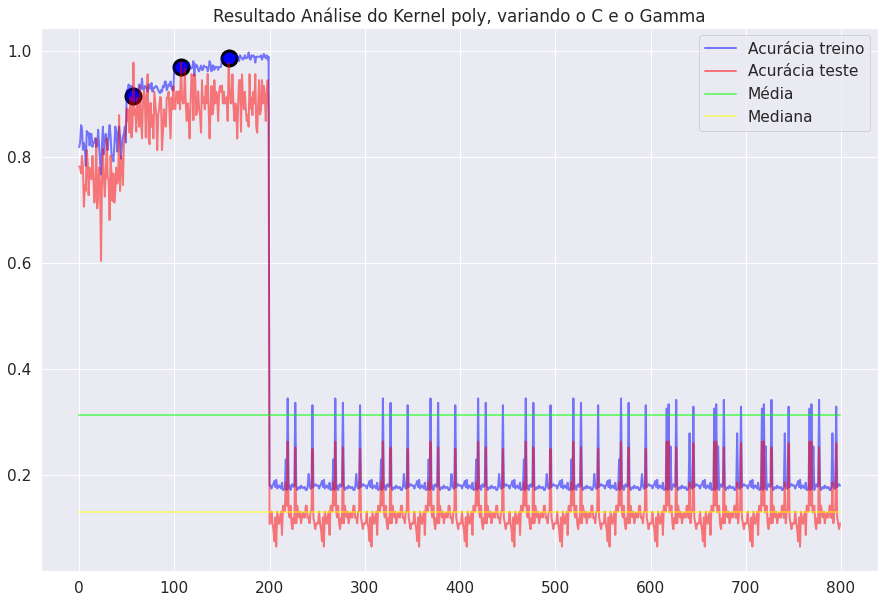

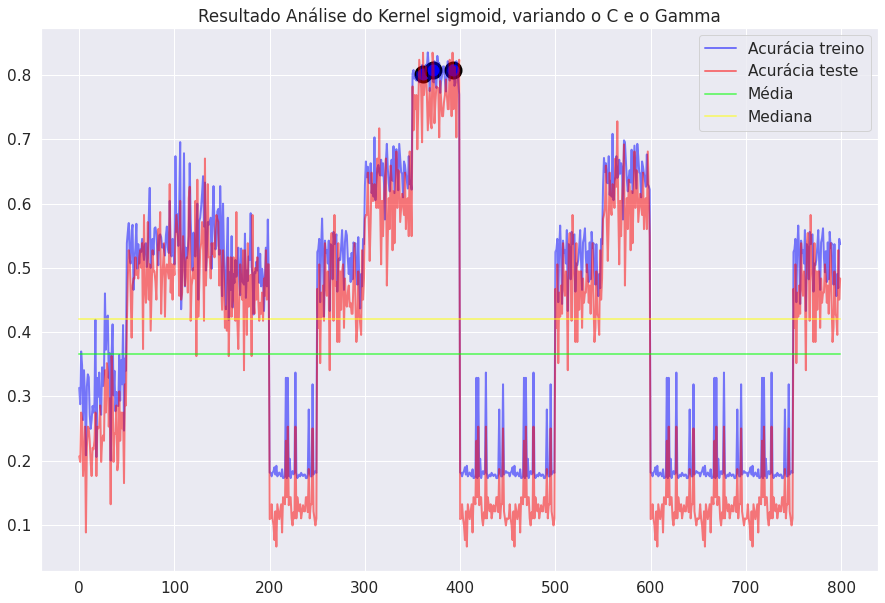

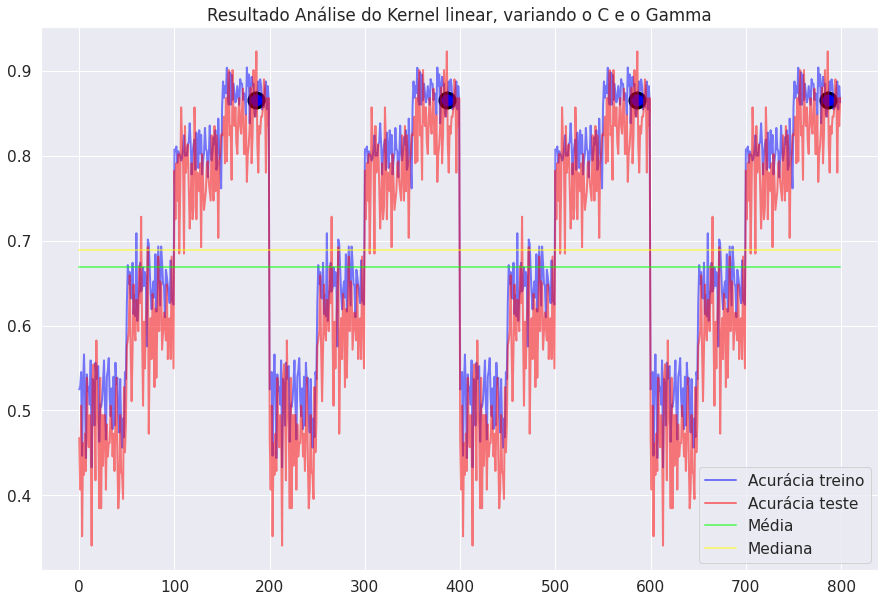

In [ ]:
def makePlotClassification(kernel):
    fig, graf = plt.subplots(figsize=(15,10))
    meanScoreTest = df_results[df_results["K"] == kernel]["MeanScoreTest"]
    meanScoreTraining = df_results[df_results["K"] == kernel]["MeanScoreTraining"]
    kernelDF = df_results[df_results["K"] == kernel]
    kernelDF.reset_index(inplace=True)
    
    df_max = kernelDF[kernelDF["MeanScoreTest"] == max(kernelDF["MeanScoreTest"])]
    print(f"Config: {df_max}, Index:{df_max.index[0]}")
    
    graf.set_title(f'Resultado Análise do Kernel {kernel}, variando o C e o Gamma')

    if(len(df_max.index) > 1):
        [graf.plot(df_max.index[i], df_max.iloc[i,4], 'o', color='red', markeredgewidth=3, markersize=15, linewidth=4,
         markerfacecolor='blue',
         markeredgecolor='black') for i in range(len(df_max.index))]
    else:
        graf.plot(df_max.index[0], df_max["MeanScoreTraining"], 'o', color='red', markeredgewidth=3, markersize=15, linewidth=4,
         markerfacecolor='blue',
         markeredgecolor='black')

    graf.plot(list(range(len(meanScoreTraining))), meanScoreTraining,color='#0000FF', label='Acurácia treino', linewidth=2, alpha=0.5)
    graf.plot(list(range(len(meanScoreTest))), meanScoreTest,color='#FF0000', label='Acurácia teste', linewidth=2, alpha=0.5)
    graf.plot(list(range(len(meanScoreTest))),[np.mean(meanScoreTest)]*len(meanScoreTest),color='#00FF00', label='Média', linewidth=2, alpha=0.5)
    graf.plot(list(range(len(meanScoreTest))),[np.median(meanScoreTest)]*len(meanScoreTest),color='#FFFF0F', label='Mediana', linewidth=2, alpha=0.5)
    graf.legend()
    #print(f"Configuração com maior acurácia no teste: {configWithMaxAccuracy}")
    print(f"Média da acurácia para todas as variações do kernel {kernel}: {np.mean(meanScoreTest)} \nMédia do desvio padrão {np.mean(np.std(meanScoreTest))}")
    print("-------------------------------------------------------------------------------------------------")
    return fig, graf
plots = list(map(lambda kernel: makePlotClassification(kernel), kernels))


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_res, y_res, test_size=0.4, random_state=42)
    
svm = SVC(kernel="rbf", degree=8, gamma=1.0 ,C=1000,decision_function_shape='ovo').fit(X_train, y_train) 
treiningScore = svm.fit(X_train,y_train).score(X_train,y_train)
y_pred = svm.predict(X_test)
confusionMatrix = confusion_matrix(y_test, y_pred)
print(f"Acurácia:{accuracy_score(y_test, y_pred)}")

Acurácia:0.8743169398907104


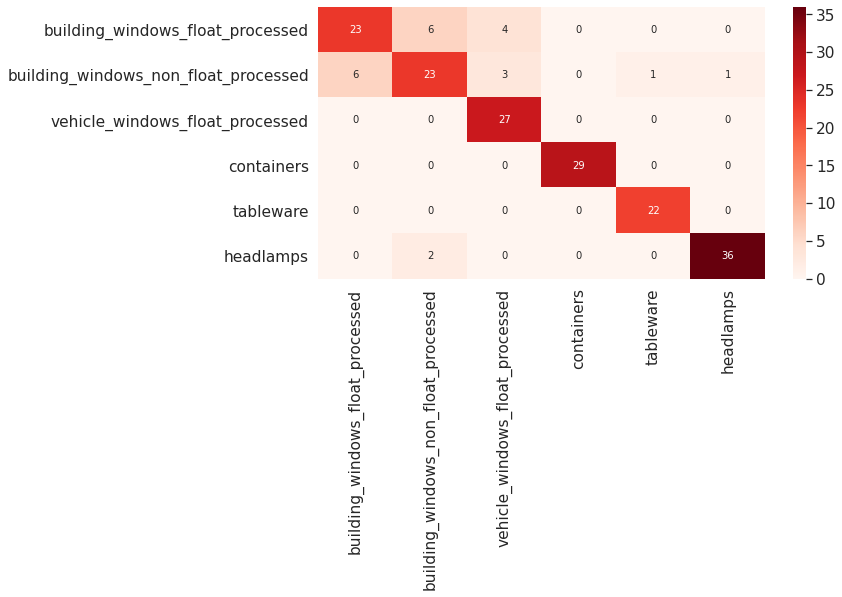

In [ ]:
plt.figure(figsize = (10,5))
sns.set(font_scale=1.4)#for label size
sns.heatmap(confusionMatrix, annot=True,annot_kws={"size": 10} , fmt='d', cmap="Reds" ,xticklabels= y_vars , yticklabels=y_vars)

Fazer GridSearchCV

In [ ]:
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid','linear']}

def atribuirTrainTestGrid(train_index, test_index, param_grid):
    X_train, X_test = x_res[train_index], x_res[test_index]
    y_train, y_test = y_res[train_index], y_res[test_index]
    grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=2) 
    treiningScore = grid.fit(X_train,y_train).score(X_train,y_train)
    #print(grid.best_estimator_)
    y_pred = grid.predict(X_test)
    grid_predictions = accuracy_score(y_pred, y_test )
    #print(confusion_matrix(y_test,grid_predictions))
    #print(classification_report(y_test,grid_predictions))#Output

    return [treiningScore, grid_predictions, grid.best_estimator_]

resultGrid = [atribuirTrainTestGrid(train_index, test_index, param_grid ) for train_index, test_index in rkf.split(x_res)]
finalDFGRID = pd.DataFrame(resultGrid,columns=["MeanScoreTraining","MeanScoreTest", "BestEstimator"])
finalDFGRID

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ..........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] .................... C=0.1, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] .................... C=0.1, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] .................... C=0.1, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] .................... C=0.1, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] .................... C=0.1, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=sigmoid ................................
[CV] ................. C=0.1, gamma=0.1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=sigmoid ................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ..........

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] .................... C=0.1, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] .................... C=0.1, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] .................... C=0.1, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] .................... C=0.1, gamma=0.1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=poly ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ..........

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ..................... C=0.1, gamma=0.1, kernel=rbf, total=   0.0s
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .................... C=0.1, gamma=1, kernel=linear, total=   0.0s
[CV] C=0.1, gamma=1, kernel=linear ...................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=0.1, gamma=1, kernel=sigmoid, total=   0.0s
[CV] C=0.1, gamma=1, kernel=sigmoid ..................................
[CV] .

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    2.5s finished


MeanScoreTraining  ...                                      BestEstimator
0            0.939560  ...  SVC(C=100, break_ties=False, cache_size=200, c...
1            0.934247  ...  SVC(C=100, break_ties=False, cache_size=200, c...
2            0.945205  ...  SVC(C=100, break_ties=False, cache_size=200, c...
3            0.934247  ...  SVC(C=100, break_ties=False, cache_size=200, c...
4            0.939726  ...  SVC(C=100, break_ties=False, cache_size=200, c...
5            0.936813  ...  SVC(C=100, break_ties=False, cache_size=200, c...
6            0.931507  ...  SVC(C=100, break_ties=False, cache_size=200, c...
7            0.942466  ...  SVC(C=100, break_ties=False, cache_size=200, c...
8            0.945205  ...  SVC(C=100, break_ties=False, cache_size=200, c...
9            0.950685  ...  SVC(C=100, break_ties=False, cache_size=200, c...
10           0.956044  ...  SVC(C=100, break_ties=False, cache_size=200, c...
11           0.942466  ...  SVC(C=100, break_ties=False, cache_size=200, c...
12           0.936986  ...  SVC(C=100, break_ties=False, cache_size=200, c...
13           0.942466  ...  SVC(C=100, break_ties=False, cache_size=200, c...
14           0.934247  ...  SVC(C=100, break_ties=False, cache_size=200, c...
15           0.934066  ...  SVC(C=100, break_ties=False, cache_size=200, c...
16           0.961644  ...  SVC(C=100, break_ties=False, cache_size=200, c...
17           0.947945  ...  SVC(C=100, break_ties=False, cache_size=200, c...
18           0.945205  ...  SVC(C=100, break_ties=False, cache_size=200, c...
19           0.950685  ...  SVC(C=100, break_ties=False, cache_size=200, c...
20           0.961538  ...  SVC(C=100, break_ties=False, cache_size=200, c...
21           0.947945  ...  SVC(C=100, break_ties=False, cache_size=200, c...
22           0.926027  ...  SVC(C=100, break_ties=False, cache_size=200, c...
23           0.947945  ...  SVC(C=100, break_ties=False, cache_size=200, c...
24           0.945205  ...  SVC(C=100, break_ties=False, cache_size=200, c...
25           0.953297  ...  SVC(C=100, break_ties=False, cache_size=200, c...
26           0.950685  ...  SVC(C=100, break_ties=False, cache_size=200, c...
27           0.945205  ...  SVC(C=100, break_ties=False, cache_size=200, c...
28           0.936986  ...  SVC(C=100, break_ties=False, cache_size=200, c...
29           0.953425  ...  SVC(C=100, break_ties=False, cache_size=200, c...
30           0.934066  ...  SVC(C=100, break_ties=False, cache_size=200, c...
31           0.950685  ...  SVC(C=100, break_ties=False, cache_size=200, c...
32           0.936986  ...  SVC(C=100, break_ties=False, cache_size=200, c...
33           0.931507  ...  SVC(C=100, break_ties=False, cache_size=200, c...
34           0.934247  ...  SVC(C=100, break_ties=False, cache_size=200, c...
35           0.934066  ...  SVC(C=100, break_ties=False, cache_size=200, c...
36           0.956164  ...  SVC(C=100, break_ties=False, cache_size=200, c...
37           0.964384  ...  SVC(C=100, break_ties=False, cache_size=200, c...
38           0.942466  ...  SVC(C=100, break_ties=False, cache_size=200, c...
39           0.942466  ...  SVC(C=100, break_ties=False, cache_size=200, c...
40           0.942308  ...  SVC(C=100, break_ties=False, cache_size=200, c...
41           0.956164  ...  SVC(C=100, break_ties=False, cache_size=200, c...
42           0.945205  ...  SVC(C=100, break_ties=False, cache_size=200, c...
43           0.939726  ...  SVC(C=100, break_ties=False, cache_size=200, c...
44           0.953425  ...  SVC(C=100, break_ties=False, cache_size=200, c...
45           0.945055  ...  SVC(C=100, break_ties=False, cache_size=200, c...
46           0.956164  ...  SVC(C=100, break_ties=False, cache_size=200, c...
47           0.947945  ...  SVC(C=100, break_ties=False, cache_size=200, c...
48           0.947945  ...  SVC(C=100, break_ties=False, cache_size=200, c...
49           0.945205  ...  SVC(C=100, break_ties=False, cache_size=200, c...

[50 rows x 3 columns]

In [ ]:
theBast = finalDFGRID[finalDFGRID["MeanScoreTest"] == max(finalDFGRID["MeanScoreTest"])]
print(f"melhor configuração encontrada:")
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(theBast)

melhor configuração encontrada:
   MeanScoreTraining  MeanScoreTest  \
7           0.942466       0.967033   

                                       BestEstimator  
7  SVC(C=100, break_ties=False, cache_size=200, c...  


# Desempenho médio das abordagéns

# Discussões

# Conslusões 

# Referências

*   [https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/]
*   [https://www.sciencedirect.com/science/article/pii/S092523120800307X#sec2]
*   [https://www.sciencedirect.com/science/article/pii/S0925231204005223]
*   [https://machinelearningmastery.com/one-vs-rest-and-one-vs-one-for-multi-class-classification/]
*   [https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RepeatedKFold.html]
*   [https://medium.com/@aneesha/svm-parameter-tuning-in-scikit-learn-using-gridsearchcv-2413c02125a0]


